In [25]:
import librosa 
from Praat import Praat_IdeaLogic as PLogic
from PIL import Image
import os
import glob
import joblib
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [26]:
def extract(audio_file):
    name=os.path.basename(audio_file)
    name=os.path.splitext(name)[0]
    label = int(name[7:8]) - 1
    
    return label, audio_file

# Spectral centroid

In [27]:
def get_feats(audio_file):
    FRAME_SIZE = 1024
    HOP_LENGTH = 512
    
    X, sample_rate = librosa.load(audio_file,
                                  res_type='kaiser_fast')
    
    # sc 
    sc = librosa.feature.spectral_centroid(y=X, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    
    return sc

def return_feats(dir_name):
    X = []
    y = []
    err_cnt = 0
    err_list = []
    exeption_list = []
    
    #progression bar 
    file_count = len(dir_name)
    bar = tqdm(desc="proccessing files", total=file_count)
    tot = 0
    
    for file in dir_name:
        bar.update(1)
        tot += 1
        label, audio_file = extract(file)
        
        try:
            X.append(get_feats(audio_file))
            y.append(label)
        except Exception as e:

            err_cnt += 1
            err_list.append(audio_file)
            exeption_list.append(str(e))
            print("{}.error at:".format(err_cnt), audio_file)
            
        
    return X, y, err_cnt, err_list, exeption_list

In [38]:
#dir_name = glob.glob("../raw data/toronto_ds/conc_data/*.wav")
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised
#dir_name = glob.glob("../raw data/Audio_Data/Actor_09/*.wav")
surprised_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-08-01-01-01-09.wav")#"03-01-08-01-01-01-09.wav"
disgust_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-07-01-01-01-09.wav")# "03-01-07-01-01-01-09.wav"
fearful_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-06-01-01-01-09.wav")# "03-01-06-01-01-01-09.wav"
angry_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-05-01-01-01-09.wav")# "03-01-08-01-01-01-09.wav"
sad_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-04-01-01-01-09.wav")# "03-01-07-01-01-01-09.wav"
happy_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-03-01-01-01-09.wav")# "03-01-06-01-01-01-09.wav"
calm_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-02-01-01-01-09.wav")# "03-01-08-01-01-01-09.wav"
neutral_X = get_feats("../raw data/Audio_Data/Actor_09/03-01-01-01-01-01-09.wav")# "03-01-07-01-01-01-09.wav"
#X, y,_,_,exception_list = return_feats(dir_name) 

In [29]:
exception_list

[]

ValueError: x and y must have same first dimension, but have shapes (133,) and (147,)

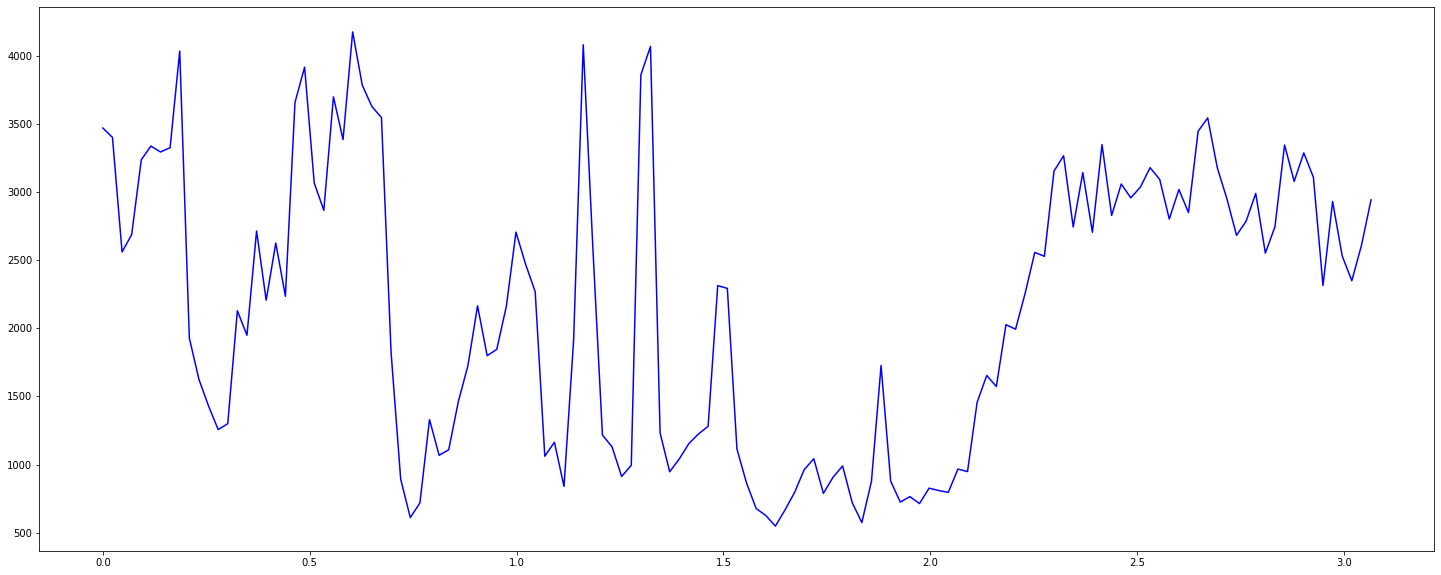

In [45]:
frames = range(len(surprised_X))
t = librosa.frames_to_time(frames)
plt.figure(figsize=(25,10))
plt.plot(t, surprised_X, color="b")
plt.plot(t, disgust_X, color="r")
plt.plot(t, fearful_X, color="y")
plt.plot(t, angry_X, color="g")
plt.plot(t, sad_X, color="magenta")
plt.plot(t, happy_X, color="cyan")
plt.plot(t, calm_X, color="black")
plt.title("Moods")
plt.show()

# frames = range(len(disgust_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, disgust_X, color="b")
# plt.title("Disgust")
# plt.show()

# frames = range(len(fearful_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, fearful_X, color="b")
# plt.title("fearful")
# plt.show()

# frames = range(len(angry_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, angry_X, color="b")
# plt.title("angry")
# plt.show()

# frames = range(len(sad_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, sad_X, color="b")
# plt.title("sad")
# plt.show()

# frames = range(len(happy_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, happy_X, color="b")
# plt.title("happy")
# plt.show()

# frames = range(len(calm_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, calm_X, color="b")
# plt.title("calm")
# plt.show()

# frames = range(len(neutral_X))
# t = librosa.frames_to_time(frames)
# plt.figure(figsize=(25,10))
# plt.plot(t, neutral_X, color="b")
# plt.title("neutral")
# plt.show()

## Whole dataset

In [47]:
dir_name = glob.glob("../raw data/toronto_ds/conc_data/*.wav")
X, y,_,_,exception_list = return_feats(dir_name) 

X = np.asarray.(X)
y = np.asarray.(y)

SyntaxError: invalid syntax (<ipython-input-47-1c0600f491be>, line 4)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

start_time = time.time()

model = XGBClassifier(learning_rate = 0.1,
                      n_estimators = 1000,
                      max_depth = 8,
                      min_child_weight=3,
                      subsample = 0.8,
                      colsample_bytree = 0.8,
                      gamma = 0
                     )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print("--- Model trained. Training time: %s seconds ---" % (time.time() - start_time))

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AttributeError: 'list' object has no attribute 'shape'